# Isochrone Match

In this notebook I will match observed NUVo measurements to theoretical NUVo predictions for isochrones of age ~30Myr. I will use this matching shema to estimate the masses of individual stars, assess the region's mass function, and calculated an estimated total stellar mass for the SMC Wing.

In [81]:
# Standard imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pylab import *
import scipy as scipy
from scipy import stats
import scipy.integrate as integrate
import itertools
from astropy.io import fits

## Workflow without applying any color / (NUV)o thresholds to data

In [82]:
# Original files
SMC_daofind_braun_id_coords_color_nuv = np.genfromtxt('SMC_daofind_braun_id_coords_color_nuv')

# Uncorrected variables
id_number_nocorr = SMC_daofind_braun_id_coords_color_nuv[:,0]
ra_nocorr = SMC_daofind_braun_id_coords_color_nuv[:,1]
dec_nocorr = SMC_daofind_braun_id_coords_color_nuv[:,2]
nuv_v_nocorr = SMC_daofind_braun_id_coords_color_nuv[:,3]
nuv_nocorr = SMC_daofind_braun_id_coords_color_nuv[:,4]

# Corrected variables (including absolute mag correction and extinction correction)
id_number_corr = id_number_nocorr
ra_corr = ra_nocorr
dec_corr = dec_nocorr
nuv_v_corr = nuv_v_nocorr - 0.26
nuv_corr = nuv_nocorr - 18.7 - 0.42
v_corr = nuv_corr - nuv_v_corr # The v extinction correction of - 0.16 is "built in" to the defintion of the nuv_v color.

# Brightness cut
id_number_cut = id_number_corr[nuv_corr <= 0.45]
ra_cut = ra_corr[nuv_corr <= 0.45]
dec_cut = dec_corr[nuv_corr <= 0.45]
nuv_v_cut = nuv_v_corr[nuv_corr <= 0.45]
nuv_cut = nuv_corr[nuv_corr <= 0.45]
v_cut = v_corr[nuv_corr <= 0.45]

# Correction between GALEX catalog vs. daophot
id_number = id_number_cut
ra = ra_cut
dec = dec_cut
nuv_v = nuv_v_cut + 0.6
nuv = nuv_cut + 0.6
v = v_cut

print(nuv[0:5])

[ 0.417 -0.103 -0.7    0.387 -1.564]


In [83]:
# Defining an isochrone model
# The file "Sep11_Isochrone_Sequence_Clean_II" is a clean version of the output file "output793322209342.dat",
# which has been renamed "output_isochrone_for_this_study" out of frustration.

Sep11_model = np.genfromtxt('Sep11_Isochrone_Sequence_Clean_II', delimiter=' ')
# Sep11_model70 = Sep11_model[Sep11_model[:,2]==1.00e+07]
Sep11_model75 = Sep11_model[Sep11_model[:,2]==3.16e+07]
# Sep11_model80 = Sep11_model[Sep11_model[:,2]==1.00e+08]
# Sep11_model85 = Sep11_model[Sep11_model[:,2]==3.16e+08]

In [84]:
# Converting Vega mags to AB mags
model = Sep11_model75
model_nuv = Sep11_model75[:,25] + 1.70
model_v = Sep11_model75[:,28]
model_color = Sep11_model75[:,0] + 1.70

In [85]:
# Setting up variables for the observed-model match
observed_nuv = nuv

In [86]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [87]:
# Define matching function
# NOTE: The magnitude in the output file is the VEGA magnitude, NOT the AB magnitude!!

output_file = open('May27_nuv_isochrone75_match', 'w')
magnitude_isochrone = []
for i in observed_nuv:
    nearest_model_nuv_value = find_nearest(model_nuv, i)
    model_entire_row = model[np.where(model_nuv == nearest_model_nuv_value)]
    i_as_array = np.asarray([[i]])
    magnitude_isochrone.append([i_as_array, model_entire_row])
    output_file.write("%s %s\n" % (i_as_array, model_entire_row))
output_file.close()

In [88]:
# Cleaning output file
# First submit the following commands
# !tr -d '\n' < May27_nuv_isochrone75_match > May27_nuv_isochrone75_match_2
# !tr '[[' '\n' < May27_nuv_isochrone75_match_2 > May27_nuv_isochrone75_match_3
# !tr ']]' ' ' < May27_nuv_isochrone75_match_3 > May27_nuv_isochrone75_match_4
# !grep . May27_nuv_isochrone75_match_4 > May27_nuv_isochrone75_match_5

# Here is where it gets a bit tricky. For the cases in which there were two isochrone steps with the same
# NUV value, the function above prints both of them! So instead of output [NUV][Isochrone Info], it prints
# [NUV][Isochrone Info][Isochrone Info]. To correct for this, I will manually remove the second isochrone 
# from "May27_nuv_isochrone75_match_5" until I learn a better way to do this. 
# The troublesome NUV magnitudes are -5.818 and -4.882.

# !sed 'N;s/\n/ /' May27_nuv_isochrone75_match_5 > May27_nuv_isochrone75_match_6
# !awk 'NF==30{print}{}' May27_nuv_isochrone75_match_6 > May27_nuv_isochrone75_match_clean
# !wc -l May27_nuv_isochrone75_match_clean

In [89]:
# Uploading the cleaned file
May27_nuv_isochrone75_match_clean = np.genfromtxt('May27_nuv_isochrone75_match_clean')

# Double-check
# Note: it's okay if the following values are not exactly the same. The "nearest" function above matches each
# observed NUVo value to the //nearest// theoretical NUVo value. It is unlikely that any match will give the 
# exact same values.
# print May27_nuv_isochrone75_match_clean[:,26][0] + 1.70
# print observed_nuv[0]

In [90]:
# Define variables based on match
# Remeber to convert Vega --> AB on the model magnitudes
observed_nuv_after = May27_nuv_isochrone75_match_clean[:,0]
model_nuv_after = May27_nuv_isochrone75_match_clean[:,26] + 1.70
model_v_after = May27_nuv_isochrone75_match_clean[:,29]
model_color_after = May27_nuv_isochrone75_match_clean[:,1] + 1.70

age = May27_nuv_isochrone75_match_clean[:,3]
mass = May27_nuv_isochrone75_match_clean[:,5]
logL = May27_nuv_isochrone75_match_clean[:,6]

# Double-check
# print model_color_after[1]
# print model_nuv_after[1] - model_v_after[1]

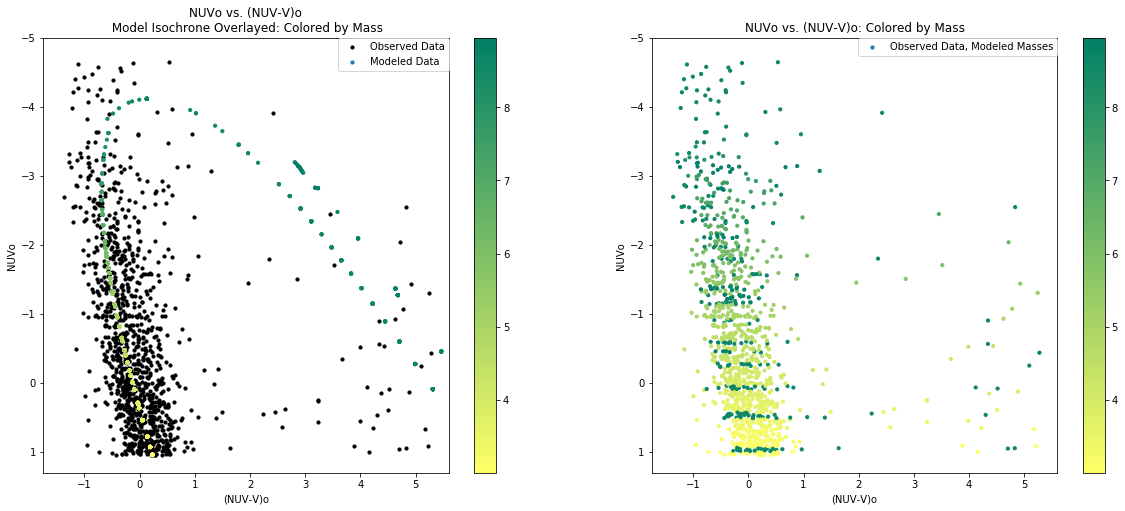

In [91]:
# Plot observed CMD with markers colored according to their associated theoretical mass.

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(nuv_v, nuv, color='black', label="Observed Data", s=10, marker="o")
plt.scatter(model_color_after, model_nuv_after, c=mass, label="Modeled Data", s=10, marker="o", cmap="summer_r")
plt.xlabel('(NUV-V)o')
plt.ylabel('NUVo')
plt.title('NUVo vs. (NUV-V)o\n Model Isochrone Overlayed: Colored by Mass')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.ylim(1.3,-5.)
plt.xlim(-1.75, 5.6)
plt.colorbar()

plt.subplot(122)
plt.scatter(nuv_v, nuv, c=mass, label="Observed Data, Modeled Masses", s=10, marker="o", cmap="summer_r")
plt.xlabel('(NUV-V)o')
plt.ylabel('NUVo')
plt.title('NUVo vs. (NUV-V)o: Colored by Mass')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.ylim(1.3,-5.)
plt.xlim(-1.75, 5.6)
plt.colorbar()

plt.show()

## Analysis

What we see in the above plots is that the "nearest" function has worked perfectly! It has matched observed NUVo values with their closest theoretical NUVo values, whether or not they make any physical sense. And, since our isochrone contains evolved, high-mass stars, the results of the above match indeed to not make physical sense (see the 'bands' of high-mass stars throughout the main sequence). To alleviate this issue, we are going to remove the evolved, high-mass stars from both the isochrone model sample and the observed sample. We have assessed that these stars are too few in number and live too briefly to significantly alter the results of this study.

Below we repeat the workflow with the applied color / magnitude limits as described above.

## Workflow with an applied color / magnitude threshold to both observed and model data

In [92]:
# Applying color threshold to observed data
obs_ct = np.where(nuv_v < 1.23)
id_number_ct = id_number[obs_ct]
ra_ct = ra[obs_ct]
dec_ct = dec[obs_ct]
nuv_v_ct = nuv_v[obs_ct]
nuv_ct = nuv[obs_ct]
v_ct = v[obs_ct]

print(nuv_v_ct.shape)

(1057,)


In [93]:
# Apply color and nuv thresholds to model
model_thresh = np.where(np.logical_and(model_color < 1.23, model_nuv < 1.15))
model_ct = model[model_thresh]
model_nuv_ct = model_nuv[model_thresh]
model_v_ct = model_v[model_thresh]
model_color_ct = model_color[model_thresh]

print(model_color_ct.shape)

(83,)


In [94]:
# Setting up variables for the observed-model match with color threshold
observed_nuv_ct = nuv_ct
print(observed_nuv_ct.shape)

(1057,)


In [95]:
# Define matching function with color threshold
output_file = open('June11_nuv_isochrone75_match', 'w')
magnitude_isochrone = []
for i in observed_nuv_ct:
    nearest_model_nuv_value = find_nearest(model_nuv_ct, i)
    model_entire_row = model_ct[np.where(model_nuv_ct == nearest_model_nuv_value)]
    i_as_array = np.asarray([[i]])
    # print(i_as_array, model_entire_row)
    magnitude_isochrone.append([i_as_array, model_entire_row])
    output_file.write("%s %s\n" % (i_as_array, model_entire_row))
output_file.close()

In [96]:
# Cleaning output file with color threshold
# First submit the following commands
# !tr -d '\n' < June11_nuv_isochrone75_match > June11_nuv_isochrone75_match_2
# !tr '[[' '\n' < June11_nuv_isochrone75_match_2 > June11_nuv_isochrone75_match_3
# !tr ']]' ' ' < June11_nuv_isochrone75_match_3 > June11_nuv_isochrone75_match_4
# !grep . June11_nuv_isochrone75_match_4 > June11_nuv_isochrone75_match_5

# Here is where it gets a bit tricky. For the cases in which there were two isochrone steps with the same
# NUV value, the function above prints both of them! So instead of output [NUV][Isochrone Info], it prints
# [NUV][Isochrone Info][Isochrone Info]. To correct for this, I will manually remove the second isochrone 
# from "June11_nuv_isochrone75_match_5" until I learn a better way to do this. 
# The troublesome NUV magnitude is -5.818, and there are 18 instances of this error.

# !sed 'N;s/\n/ /' June11_nuv_isochrone75_match_5 > June11_nuv_isochrone75_match_6
# !awk 'NF<=30{print}{}' June11_nuv_isochrone75_match_6 > June11_nuv_isochrone75_match_clean
# !wc -l June11_nuv_isochrone75_match_clean

In [97]:
# Uploading the cleaned file (for color threshold)
June11_nuv_isochrone75_match_clean = np.genfromtxt('June11_nuv_isochrone75_match_clean')

# Double-check
# print June11_nuv_isochrone75_match_clean[:,26][0] + 1.70
# print observed_nuv_ct[0]

In [98]:
# Define variables based on match (for color threshold)
# Remeber to convert Vega --> AB on the model magnitudes
observed_nuv_after_ct = June11_nuv_isochrone75_match_clean[:,0]
model_nuv_after_ct = June11_nuv_isochrone75_match_clean[:,26] + 1.70
model_v_after_ct = June11_nuv_isochrone75_match_clean[:,29]
model_color_after_ct = June11_nuv_isochrone75_match_clean[:,1] + 1.70

age_ct = June11_nuv_isochrone75_match_clean[:,3]
mass_ct = June11_nuv_isochrone75_match_clean[:,5]
logL_ct = June11_nuv_isochrone75_match_clean[:,6]

# Double-check
# print model_color_after_ct[1]
# print model_nuv_after_ct[1] - model_v_after_ct[1]

# Color-magnitude diagram with isochrones

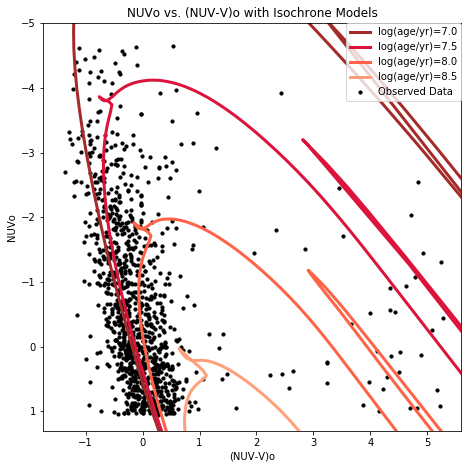

In [99]:
plt.figure(figsize=(7.5,7.5))

# # model
model_all = np.genfromtxt('../../../NGC 602 Sept 7/Sep11_Isochrone_Sequence_Clean_II', delimiter=' ')
model70 = Sep11_model[Sep11_model[:,2]==1.00e+07]
model75 = Sep11_model[Sep11_model[:,2]==3.16e+07]
model80 = Sep11_model[Sep11_model[:,2]==1.00e+08]
model85 = Sep11_model[Sep11_model[:,2]==3.16e+08]

model70_nuv = model70[:,25] + 1.70
model70_v = model70[:,28]
model70_nuvcolor = model70[:,0] + 1.70
model70_bcolor = model70[:,27] - model70[:,28]

model75_nuv = model75[:,25] + 1.70
model75_v = model75[:,28]
model75_nuvcolor = model75[:,0] + 1.70
model75_bcolor = model75[:,27] - model75[:,28]

model80_nuv = model80[:,25] + 1.70
model80_v = model80[:,28]
model80_nuvcolor = model80[:,0] + 1.70
model80_bcolor = model80[:,27] - model80[:,28]

model85_nuv = model85[:,25] + 1.70
model85_v = model85[:,28]
model85_nuvcolor = model85[:,0] + 1.70
model85_bcolor = model85[:,27] - model85[:,28]

plt.scatter(nuv_v, nuv, color='black', label="Observed Data", s=10, marker="o")
plt.plot(model70_nuvcolor[model70_nuv>=-5.2], model70_nuv[model70_nuv>=-5.2], color='brown', label='log(age/yr)=7.0', linewidth=3)
plt.plot(model75_nuvcolor[model75_nuv>=-4.7], model75_nuv[model75_nuv>=-4.7], color='crimson', label='log(age/yr)=7.5', linewidth=3)
plt.plot(model80_nuvcolor[model80_nuv>=-4.7], model80_nuv[model80_nuv>=-4.7], color='tomato', label='log(age/yr)=8.0', linewidth=3)
plt.plot(model85_nuvcolor[model85_nuv>=-4.7], model85_nuv[model85_nuv>=-4.7], color='lightsalmon', label='log(age/yr)=8.5', linewidth=3)

plt.xlabel('(NUV-V)o')
plt.ylabel('NUVo')
plt.title('NUVo vs. (NUV-V)o with Isochrone Models')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.ylim(1.3,-5.)
plt.xlim(-1.75, 5.6)

plt.show()

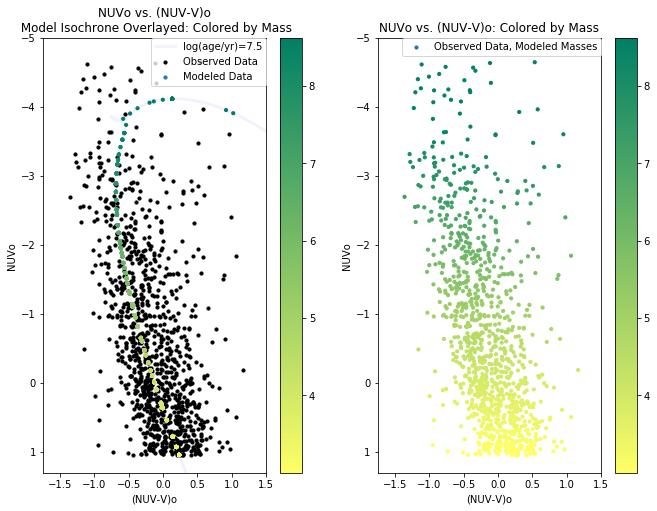

In [100]:
# Plot observed CMD with markers colored according to their associated theoretical mass.

plt.figure(figsize=(11,8))
plt.subplot(121)
plt.scatter(nuv_v_ct, nuv_ct, color='black', label="Observed Data", s=10, marker="o")
plt.scatter(model_color_after_ct, model_nuv_after_ct, c=mass_ct, label="Modeled Data", s=10, marker="o", cmap="summer_r")
plt.plot(model75_nuvcolor[model75_nuv>=-4.7], model75_nuv[model75_nuv>=-4.7], color='blue', label='log(age/yr)=7.5', linewidth=3, alpha=0.05)

plt.xlabel('(NUV-V)o')
plt.ylabel('NUVo')
plt.title('NUVo vs. (NUV-V)o\n Model Isochrone Overlayed: Colored by Mass')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.ylim(1.3,-5.)
plt.xlim(-1.75, 1.5)
plt.colorbar()

plt.subplot(122)
plt.scatter(nuv_v_ct, nuv_ct, c=mass_ct, label="Observed Data, Modeled Masses", s=10, marker="o", cmap="summer_r")
plt.xlabel('(NUV-V)o')
plt.ylabel('NUVo')
plt.title('NUVo vs. (NUV-V)o: Colored by Mass')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.ylim(1.3,-5.)
plt.xlim(-1.75, 1.5)
plt.colorbar()

plt.show()

## Analysis

This direct relationship between mass and luminosity is logical and well-understood. Let's continue!

In [101]:
# Sum masses for all observed stars
print 'Number of Stars in Sample:', len(mass_ct)
print 'Observed Stellar Mass in Solar Masses for Sample:', np.round(sum(mass_ct), 2)
print 'Average Stellar Mass:', np.round(sum(mass_ct)/len(mass_ct), 2)
print 'Observed Stellar Luminosity in Solar Luminosities:', np.round(sum(10 ** logL_ct), 2)
print 'Average Stellar Luminosity in Solar Luminosities:', np.round(sum(10 ** logL_ct)/np.round(sum(mass_ct), 2), 2)

# Take total luminosity for the clump and subtract the star from it
# So long as you can say where they are, it doesn't matter if their arbitrary
# That was the criteria, here they are
# Don't double count!!

# Ratio of mass to UV luminosity

# Failed or reduced feedback
# Birth conditions - locally efficient star formation


Number of Stars in Sample: 1057
Observed Stellar Mass in Solar Masses for Sample: 5018.22
Average Stellar Mass: 4.75
Observed Stellar Luminosity in Solar Luminosities: 1443638.43
Average Stellar Luminosity in Solar Luminosities: 287.68


In [102]:
# Examine the mass function of these stars

frequency_density = []
avg_mass_for_each_bin = []

range = np.arange(10)

for i in range:
    one = i * 100
    hundred = one + 100
    bin_i = np.sort(mass_ct)[one:hundred]
    avg_mass_for_bin_i = np.mean(bin_i)
    avg_mass_for_each_bin.append(avg_mass_for_bin_i)
    
    mass_range_i = max(bin_i) - min(bin_i)
    freq_density = 100 / mass_range_i
    frequency_density.append(freq_density)


log_frequency_density = np.log10(frequency_density)
log_avg_mass = np.log10(avg_mass_for_each_bin)

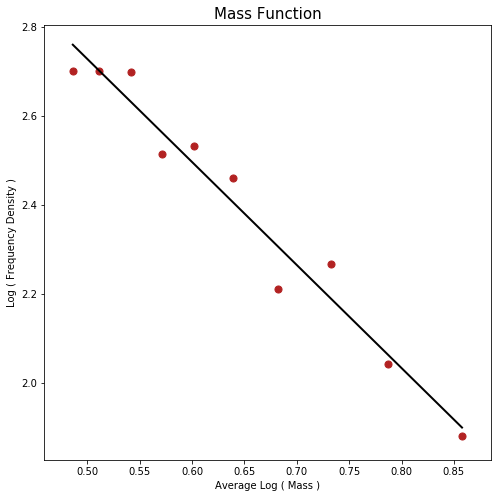

('Slope:', -2.3162525271700147)
('Intercept:', 3.8858589895865707)


In [103]:
# Plot the mass function

plt.figure(figsize=(8,8))
plt.xlabel('Average Log ( Mass )')
plt.ylabel('Log ( Frequency Density )')
plt.title('Mass Function', size=15)

plt.scatter(log_avg_mass, log_frequency_density, s=50, color='firebrick')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_avg_mass, log_frequency_density)
plt.plot(log_avg_mass, log_avg_mass * slope + intercept, linewidth=2, color='black')
plt.show()

print ("Slope:", slope)
print ("Intercept:", intercept)

In [104]:
# Compute the ratio to convert observed stellar mass to theoretical / total stellar mass

min_obs_mass = min(mass_ct)
max_obs_mass = max(mass_ct)
min_theor_mass = 0.5
max_theor_mass = max(mass_ct) + 1

theoretical = integrate.quad(lambda m: m**(slope + 1), min_theor_mass, max_theor_mass)[0] + integrate.quad(lambda m: m**(slope + 2), 0.1, 0.5)[0]
observed = integrate.quad(lambda m: m**(slope + 1), min_obs_mass, max_obs_mass)[0]
ratio = theoretical / observed

In [105]:
print 'For the following parameters:'
print ''
print 'Exponent over m in integral (based on our data) is', np.round(slope + 1, 2)
print 'Minimum observed stellar mass [solar masses]:', min_obs_mass
print 'Maximum observed stellar mass [solar masses]:', max_obs_mass
print 'Minimumtheoretical stellar mass [solar masses]:', min_theor_mass
print 'Maximum theoretical stellar mass [solar masses]:', max_theor_mass

print ''
print 'The observed stellar mass is', sum(mass_ct), 'solar masses.'
print 'The stellar mass ratio is', np.round(ratio, 2)
print 'Therefore, the theoretical stellar mass is', np.round(sum(mass_ct) * ratio, 2), 'solar masses.'

For the following parameters:

Exponent over m in integral (based on our data) is -1.32
Minimum observed stellar mass [solar masses]: 3.001
Maximum observed stellar mass [solar masses]: 8.619
Minimumtheoretical stellar mass [solar masses]: 0.5
Maximum theoretical stellar mass [solar masses]: 9.619

The observed stellar mass is 5018.221 solar masses.
The stellar mass ratio is 4.73
Therefore, the theoretical stellar mass is 23749.84 solar masses.
